# Assignment 1

Andrew Abbott  
MSDS 7331  
January 29, 2017

The data is located at [https://www.kaggle.com/START-UMD/gtd](https://www.kaggle.com/START-UMD/gtd)

## Business Understanding:

The data used in this assignment is taken from the Global Terrorism Database (GTD), maintained by the National Consortium for the Study of Terroism and Responses to Terorism (START). The GTD is open-source and contains data on more than 150,000 terrorist or possibly terrorist attacks from around the globe from 1970 to 2015 (except for 1993). There are more than one hundred attributes including location, date, taget, victims, tactics, and perpetrators.

It is important to note the definition of terrorism used in this collection.

> "The threatened or actual use of illegal force and violence by a non-state actor to attain a political, economic, religious, or social goal through fear, coercion, or intimidation."

> "The exclusive pursuit of profit does not satisfy this criterion."

I will seek to identify which charactersitics of attacks are most predictive of U.S. casualties. A good prediction algorithm would reveal a relationship between those attributes that contribute to the likelihood of American casualties.

## Data Understanding:  

The data includes 137 attributes, many of which are redundant or unrelated to the purpose of this study. A Codebook containing a description of each of the attributes can be accessed at [http://start.umd.edu/gtd/downloads/Codebook.pdf](http://start.umd.edu/gtd/downloads/Codebook.pdf).

In [116]:
import pandas as pd
import numpy as np
df = pd.read_csv('data/globalterrorismdb_0616dist.csv', encoding='ISO-8859-1', 
                 usecols=[1,2,3,8,10,19,20,21,22,26,27,29,35,41,84,71,100,101,103,104,135])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156772 entries, 0 to 156771
Data columns (total 21 columns):
iyear              156772 non-null int64
imonth             156772 non-null int64
iday               156772 non-null int64
country_txt        156772 non-null object
region_txt         156772 non-null object
crit1              156772 non-null int64
crit2              156772 non-null int64
crit3              156772 non-null int64
doubtterr          156771 non-null float64
success            156772 non-null int64
suicide            156772 non-null int64
attacktype1_txt    156772 non-null object
targtype1_txt      156772 non-null object
natlty1_txt        156772 non-null object
nperps             85640 non-null float64
weaptype1_txt      156772 non-null object
nkill              147827 non-null float64
nkillus            92315 non-null float64
nwound             142572 non-null float64
nwoundus           92066 non-null float64
INT_ANY            156772 non-null int64
dtypes: float

To verify data quality I check for missing values, outliers, and duplicates. 

For the numerical attributes containing the numbers of killed, wounded and perpetrators, the value is often missing and is replaced with a zero. Fo example if the number killed is zero the data will often omit the zero in the number of US killed. I also removed all records with zeros in the month field and replaced zero day values with 1. Next I combined the year, month, and day into a 'date' field and mapped the boolean fields into boolean types. For that mapping, -9 and -99 are mapped to False. 

There were 4 extreme outliers as far as number of perpetrators. Two of the attacks were committed by over 20,000 people and a third by 10,000. These types of attacks may be more accurately called revolts or uprisings than terror attacks so they will be excluded here.

Duplicates could occur if the same event was reported by multiple sources. I will check for duplicates and remove them.

In [258]:
df['nkill'] = df['nkill'].fillna(0).astype(int)
df['nperps'] = df['nperps'].fillna(0).astype(int)
df['nkillus'] = df['nkillus'].fillna(0).astype(int)
df['nwound'] = df['nwound'].fillna(0).astype(int)
df['nwoundus'] = df['nwoundus'].fillna(0).astype(int)
df['iyear'] = df['iyear'].astype(int)
row_index = df.iday == 0
df.loc[row_index,'iday'] = 1
df = df[(df.imonth != 0) & (df.nperps > 0) & (df.doubtterr != 1) & (df.nperps < 5000)]
df = df.dropna(subset=['country_txt'])
df['date'] = pd.to_datetime(df.iyear+df.imonth+df.iday)
d = {0:False, 1:True, -9:False}
df['crit1'] = df['crit1'].map(d)
df['crit2'] = df['crit2'].map(d)
df['crit3'] = df['crit3'].map(d)
df['doubtterr'] = df['doubtterr'].map(d)
df['suicide'] = df['suicide'].map(d)
df['success'] = df['success'].map(d)
df['Int_Motive'] = df['INT_ANY'].map(d)
df.groupby(['date','country_txt','nkill']).size() 
df = df.drop_duplicates(['date','country_txt','nkill'])

Next I create a new data frame containing only the attributes I want to keep and rename them to more readable names. I also create new variables that indicate if there was a US killed or wounded.

In [259]:
terror = df[['date','country_txt','region_txt','crit1','crit2','crit3','success','suicide','attacktype1_txt',
                  'targtype1_txt','natlty1_txt','nperps','weaptype1_txt','nkill','nkillus','nwound','nwoundus','Int_Motive']]
terror = terror.rename(
    columns = {'country_txt':'Country','region_txt':'Region','crit1':'Criteria_1','crit2':'Criteria_2',
               'crit3':'Criteria_3','success':'Success','suicide':'Suicide',
               'attacktype1_txt':'Attack_Type','targtype1_txt':'Target_Type','natlty1_txt':'Target_Nationality',
               'nperps':'Num_Perps','weaptype1_txt':'Weapon_Type','nkill':'Num_Killed','nkillus':'Num_Killed_US',
               'nwound':'Num_Wounded','nwoundus':'Num_Wounded_US'})
terrordata = terror[['Criteria_1','Criteria_2','Criteria_3','Success','Suicide','Num_Perps','Num_Killed',
                     'Num_Wounded','Int_Motive']]
terror['US_Killed'] = np.where(terror['Num_Killed_US']>0, True, False)
terror['US_Wounded'] = np.where(terror['Num_Wounded_US']>0, True, False)
ter_success = terror[(terror.Success == True)]

In [260]:
ter_success.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7449 entries, 8 to 156723
Data columns (total 20 columns):
date                  7449 non-null datetime64[ns]
Country               7449 non-null object
Region                7449 non-null object
Criteria_1            7449 non-null bool
Criteria_2            7449 non-null bool
Criteria_3            7449 non-null bool
Success               7449 non-null bool
Suicide               7449 non-null bool
Attack_Type           7449 non-null object
Target_Type           7449 non-null object
Target_Nationality    7449 non-null object
Num_Perps             7449 non-null int32
Weapon_Type           7449 non-null object
Num_Killed            7449 non-null int32
Num_Killed_US         7449 non-null int32
Num_Wounded           7449 non-null int32
Num_Wounded_US        7449 non-null int32
Int_Motive            7449 non-null bool
US_Killed             7449 non-null bool
US_Wounded            7449 non-null bool
dtypes: bool(8), datetime64[ns](1), int32(5)

### Visualize appropriate statistics:

Simple statistics for the 5 remaining numerical attributes are given below. There were 7,449 unique successful attacks with valid date, country name, at least one perpetrator counted, and no doubt about terror motive. The mean number of perpetrators is 23.8 due to outliers which may more acurately be described as uprisings. The median number of perpetrators is in fact only 3.

In [261]:
ter_success.describe()

,Num_Perps,Num_Killed,Num_Killed_US,Num_Wounded,Num_Wounded_US
count,7449.000000,7449.000000,7449.000000,7449.000000,7449.000000
mean,23.774735,7.011948,0.289972,9.231843,0.142972
std,99.975090,22.536716,16.011881,28.998905,7.589851
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,0.000000,0.000000,0.000000
75%,9.000000,7.000000,0.000000,6.000000,0.000000
max,3200.000000,1381.000000,1357.000000,750.000000,650.000000


In [262]:
ter_success.median()

Criteria_1        1.0
Criteria_2        1.0
Criteria_3        1.0
Success           1.0
Suicide           0.0
Num_Perps         3.0
Num_Killed        2.0
Num_Killed_US     0.0
Num_Wounded       0.0
Num_Wounded_US    0.0
Int_Motive        0.0
US_Killed         0.0
US_Wounded        0.0
dtype: float64

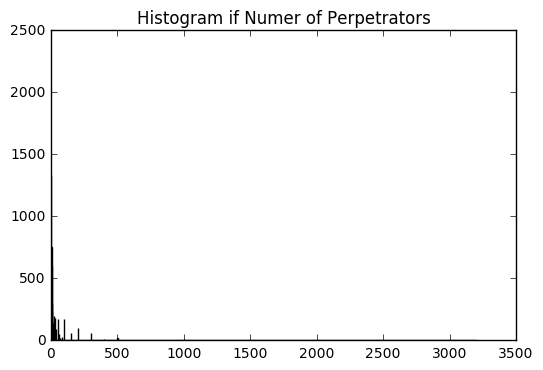

In [267]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline
plt.hist(ter_success.Num_Perps, bins='auto')
plt.title("Histogram if Numer of Perpetrators")
plt.show()

The numbers of perpetrators still have a significant range even after removing the extreme outliers, so a histogram is not particularly informative.

C:\Users\Abbott\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


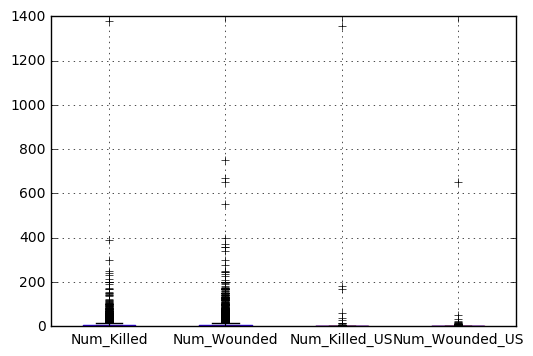

In [268]:
ax = ter_success[['Num_Killed','Num_Wounded','Num_Killed_US','Num_Wounded_US']].boxplot()
#ax.set_yscale('log')

### Interesting Attributes

In [226]:
percent_US_Killed = sum(terror['US_Killed'])/len(terror['US_Killed']) * 100
print (percent_US_Killed)

1.86791998072


1.87% of the terrorist attacks results in the death of an American.

In [227]:
percent_US_Wounded = sum(terror['US_Wounded'])/len(terror['US_Wounded']) * 100
print (percent_US_Wounded)

1.22921185828


1.23% of terrorist attacks resulted in a wounded American.

In [228]:
ter_success = terror[(terror.Success == True)]
percent_US_Killed_s = sum(ter_success['US_Killed'])/len(ter_success['US_Killed']) * 100
print (percent_US_Killed_s)

1.99946323135


The percent of attacks with Americans killed increases to 2.00% for attacks that were successful

In [229]:
percent_US_Wounded_s = sum(ter_success['US_Wounded'])/len(ter_success['US_Wounded']) * 100
print (percent_US_Wounded_s)

1.24798711755


The percent of attacks with wounded Americans only slightly increases to 1.25% for attacks that are successful.

In [230]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

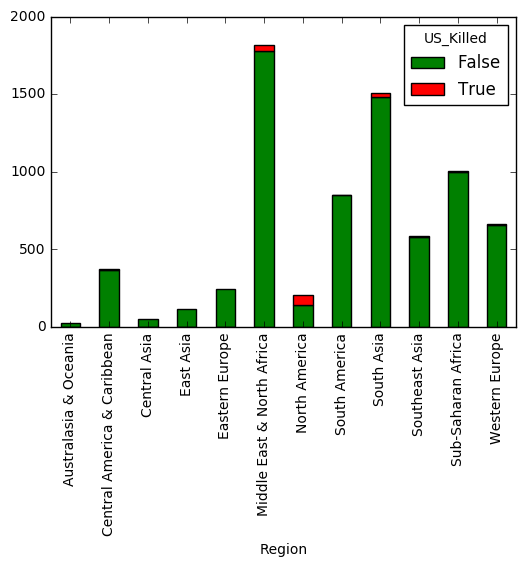

In [231]:
US_Kill_count = pd.crosstab([ter_success['Region']], ter_success.US_Killed)
US_Kill_count.plot(kind='bar', stacked=True, color=['green','red'])

The bar graph above displays the counts of successful terror attacks with and without US deaths by region. The Middle East & North Africa had the most successful attacks, followed by South Asia and Sub-Saharan Africa. North America had the most attacks with American deaths.

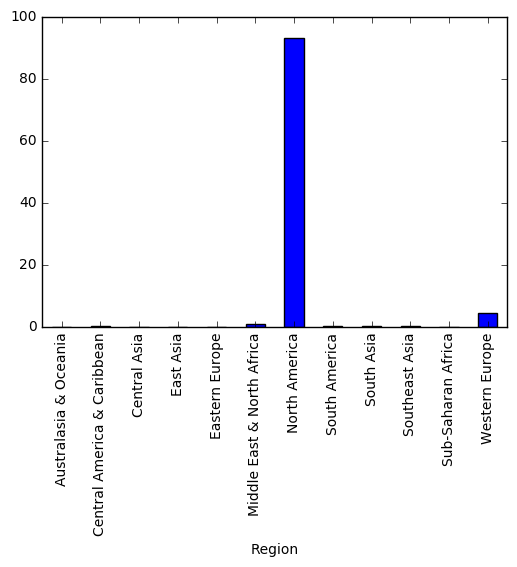

In [237]:
ter_regiongrp = ter_success.groupby(by = ['Region'])
US_killed_pct = ter_regiongrp.Num_Killed_US.sum() / ter_regiongrp.Num_Killed.sum() *100
US_killed_pct.plot(kind='bar', stacked =True)

The above chart shows the percent of those killed that were American by attack location. It is not surprising that attacks that take place in the region that includes America have more than 90% of deaths Americans.

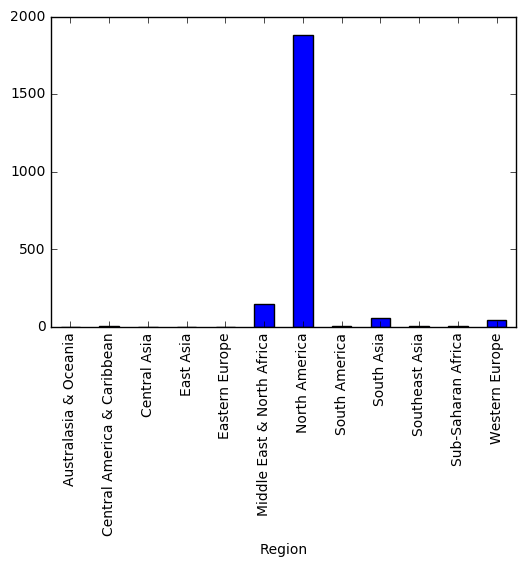

In [238]:
US_Killed_count = ter_regiongrp.Num_Killed_US.sum()
US_Killed_count.plot(kind='bar')

### Interesting Features
This data both confirms perviously held beliefs that the Mid East, Africa, and South Asia have the most terror attacks, but also reminded me of the number or historical "terror" attacks that have occurred here in North America.

### Other Features that could be added

There are many possible features to add to this for consideration. The first that come to mind are economic. What are the incomes per capita of the locations of the attacks, the unemployment rates, the inequality rates, the corruption index, etc. For the goal of predicting US deaths, not only the economic statistics of the location but also those of the perpetratos home nation and of the Unites States, all at the time of the event.

# Dimensionality Reduction

In [205]:
from pandas.tools.plotting import scatter_matrix
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [206]:
terrortarget = terror[['US_Killed']]
X = terrordata
y = terrortarget

pca = PCA(n_components=2)
X_pca = pca.fit(X).transform(X)

lda = LDA(n_components=2)
X_lda = lda.fit(X,y).transform(X)

print('pca:', pca.components_)
print('lda:', lda.scalings_.T)

pca: [[  1.15765018e-06   1.04730987e-06  -8.30196060e-06   5.69257862e-06
    1.88150835e-05  -4.45987951e-05   9.99989077e-01   2.28608057e-03
    4.07620672e-03  -3.13918093e-05]
 [ -1.70389599e-04  -7.39078116e-05  -2.20231117e-04   6.04849167e-04
   -1.02779283e-03  -5.24025627e-03   4.66915243e-03  -4.52326730e-01
   -8.91823811e-01   2.30553945e-04]]
lda: [[  9.78000451e-02   1.32605998e+00   4.87284313e-01   9.61740335e-01
    6.41675735e-01   2.05466396e-01  -4.46032733e-05   2.03016502e-02
    1.01628348e-02   1.78997388e+00]]


C:\Users\Abbott\Anaconda3\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
